In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cloning_algorithm as ca

# Introduction

In this notebook we use the cloning algorithm to evaluate a survival probability for a stochastic process $X_t$.


We first define the stochastic process we consider (which means defining a time series generator),
and then define what it means for a realization of the stochastic process to survive (which means
we define the rare event we are interested in, as implemented in the condition detector).
After showing the numerical results of our cloning algorithm, we compare the numerical
 results to analytical predictions (see "Stochastic action for tubes: Connecting path probabilities to measurement", J. Kappler, R. Adhikari, <i>Physical Review Research</i>, vol. 2, p. 023407, 2020. DOI: 10.1103/PhysRevResearch.2.023407, which can be downloaded here: https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.023407).

 # Defining the time series generator and the condition detector

### Time series generator 

We consider a diffusive stochastic process $X_t$ with increment $dX_t$ given by

\begin{align}
dX_t &= \sqrt{ 2D}\,dW_t,
\end{align}

where $D$ is the diffusivity and $dW_t$ is the increment of the Wiener process.
The time series generator below generates discretized sample trajectories for 
the stochastic process $X_t$.

### Condition detector

We consider the ensemble of trajectories that starts at $t_0=0$ at $X_0 = 0$, and
always remains within distance $R$ of the path $\varphi(t)$. The probability
to observe a sample trajectory that fulfills this condition up to time $T$ is 
called the sojourn probability 
\begin{align}
P_R^{\varphi}(T) &= P(\,|X_t - \varphi(t)| < R\quad \forall t \in [0, T] \mid X_0 = 0 \,),
\end{align}
where by writing $P_R^{\varphi}(T)$ we omit the dependence of the sojourn probability
on the initial condition.
For this particular rare event, where a stochastic trajectory remains close to 
a given reference path, we use the names "sojourn probability" and "survival probability"
interchangeably.

We now evaluate the sojourn probability $P_R^{\varphi}(T)$ for 
$D = 1/4 \,\cdot L^2/T$, $R = 1/10 \,\cdot L$, and a path

\begin{align}
\varphi(t) &= L\sin\left( 2 \pi \frac{t}{T}\right).
\end{align}

Here, $L$ is a length scale and $T$ is the final time.

In [2]:
class time_series_generator:
    '''
    This class generates stochastic time series for given number of timesteps 
    and initial state
    '''

    def __init__(self,parameters):
        #
        self.n_steps = parameters['n_steps']
        self.dt = parameters['dt']
        self.D = parameters['D']
        #
        self.t = np.arange(self.n_steps+1)*self.dt
        #
        self.noise_prefac = np.sqrt(2*self.D*self.dt)

    def get_time_series(self,x0,t0=0):
        #
        traj = np.zeros([self.n_steps+1,1],dtype=float)
        traj[0] = x0
        #
        self.rng = np.random.default_rng()
        noise = self.rng.normal(size=self.n_steps)
        #
        for i,cur_x in enumerate(traj[:-1]):
            traj[i+1] = cur_x +  self.noise_prefac*noise[i] 
        #
        return traj



class condition_detector:
    '''
    This class has a method called "evaluate_condition", which takes a time
    series and returns the array index at which the time series stops 
    fulfilling the desired condition
    '''

    def __init__(self,parameters):
        #
        self.R = parameters['R']
        #

    def x_func(self,t):
        return 1. * np.sin(2*np.pi*t)

    def evaluate_condition(self,x,t):
        '''
        Evaluate the condition on a given time series
        '''
        #
        path = self.x_func(t).reshape([len(t),1])
        #
        distance_from_path = np.fabs( x - path  )
        mask = (distance_from_path > self.R)
        #
        leaving_index = np.argmax(mask)
        #
        if leaving_index == 0:
            leaving_index = -1
        #
        return leaving_index

    def evaluate_observables(self,results):
        '''
        Here you can implement any observable that you are interested in.

        We here implement the mean and standard deviation of the survivors.
        Furthermore, we collect the final distribution of survivors at the
        end of each iteration.
        '''
        #
        # get all relevant data from input dictionary
        t = results['t']
        x = results['x']
        leaving_indices = results['leaving_index']
        n_steps = len(t)
        #
        # at each timestep, calculate mean and standard deviation of 
        # distribution of surviving time series 
        mean = np.zeros(n_steps,dtype=float)
        std = np.zeros(n_steps,dtype=float)
        for i in range(n_steps):
            mask = (leaving_indices > i+1) | (leaving_indices == -1)
            survivors = x[mask,i]
            #
            mean[i] = np.mean(survivors)
            std[i] = np.std(survivors)
        #
        # at the end of each iteration, calculate the distribution of the
        # final states of all surviving time series
        mask = (leaving_indices == -1)
        hist, bin_edges = np.histogram(x[mask,-1,0],bins=100,density=True)
        hist = hist.reshape([1,len(hist)])
        bin_edges = bin_edges.reshape([1,len(bin_edges)])
        t_hist = np.array([t[-1]])
        #
        # return dictionary with all observables
        observables = {'mean':mean,
                        'std':std,
                        'hist':hist,
                        'bin_edges':bin_edges,
                        't_hist':t_hist,
                        }
        #
        return observables


In [3]:
# parameters for simulation
t0 = 0. # initial time (relevant e.g. for time-dependent forces)
dt = 1e-5 # timestep
D = .2 # diffusivity 
x0 = [0.] # initial conditions
n_steps = 100 # number of steps per iteration

parameters_time_series_generator = {'D':D,
                                    'dt':dt,
                                    'n_steps':n_steps}
simulator = time_series_generator(parameters_time_series_generator)


# parameters for condition
R = .1 # tube radius
# note that the reference path is implemented in the condition_detector class

parameters_detector = {'R':R}
detector = condition_detector(parameters_detector)

In [4]:
# parameters for the cloning algorithm
n_iterations = 1000 # number of iterations
# NOTE: total duration = n_steps * n_iterations * dt
# Thus, if you want to simulate up to time T with a timestep dt,
# and want in total n_iterations, you should choose
# n_steps = int( T/ dt /n_iterations )
#
n_clones = 10000 # number of time series generated in first iteration
n_target = 2000 # target for time series surviving until the end of each
               #  iteration
n_clones_max = 10000 # maximal number of time series per iteration
n_cores = 2 # number of cores

verbose=True # output progress

parameters = {'t0':t0,
                'dt':dt,
                #
                'n_steps':n_steps,
                'n_iterations':n_iterations,
                'n_clones':n_clones,
                'n_cores':n_cores,
                'initial_conditions':x0,
                'n_target':n_target,
                'n_clones_max':n_clones_max,
                'verbose':verbose}

clone = ca.cloning_algorithm(parameters=parameters,
            time_series_generator=simulator,
            condition_detector=detector
            )

Plot of reference path and sample trajectory:


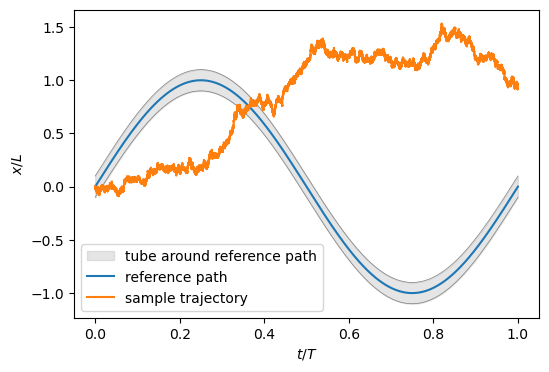

As can be seen, a typical sample trajectory does not stay close to the reference path


In [5]:
print("Plot of reference path and sample trajectory:")

t = np.arange(n_steps*n_iterations+1)*dt # time array

# generate long enough trajectory
sample_trajectory = simulator.get_time_series(x0=0.)
for i in range(n_iterations-1):
    sample_trajectory = np.concatenate((sample_trajectory[:-1],
                        simulator.get_time_series(x0=sample_trajectory[-1])),
                        axis=0)

# evaluate reference path
p = detector.x_func(t)

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.fill_between(t,p-R,p+R,color='gray',alpha=0.2,
                label='tube around reference path')
ax.plot(t,p-R,color='gray',alpha=1.,lw=0.5)
ax.plot(t,p+R,color='gray',alpha=1.,lw=0.5)
ax.plot(t,p,label='reference path')
ax.plot(t,sample_trajectory,label='sample trajectory')
ax.legend(loc='best')
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$x/L$')
plt.show()
plt.close(fig)

print("As can be seen, a typical sample trajectory does not stay close to"
      " the reference path")

# Evaluating the sojourn probability using the cloning algorithm

In [6]:
results = clone.run(filename='cloning.h5')

Finished all 1000 interations. Mean number of clones used: 2184.08.                 


In [7]:
# Content of the output dictionary of cloning_algorithm.run():
print('results.keys() =',results.keys())
# In particular:
print("results['observables'].keys() =",results['observables'].keys())

results.keys() = dict_keys(['t', 'remainers', 'survival_probability', 'exit_rate', 'n_clones', 'final_positions', 'observables', 'parameters'])
results['observables'].keys() = dict_keys(['mean', 'std', 'hist', 'bin_edges', 't_hist'])


# Plot of numerical results

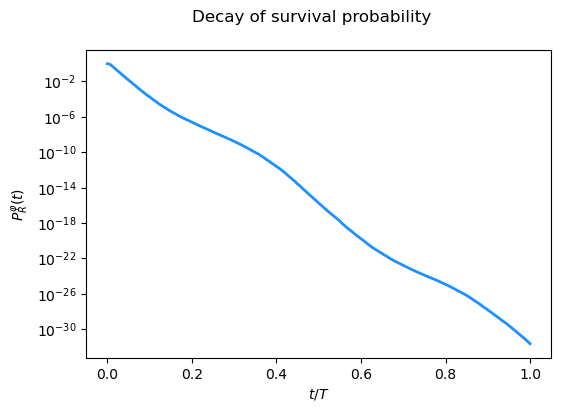

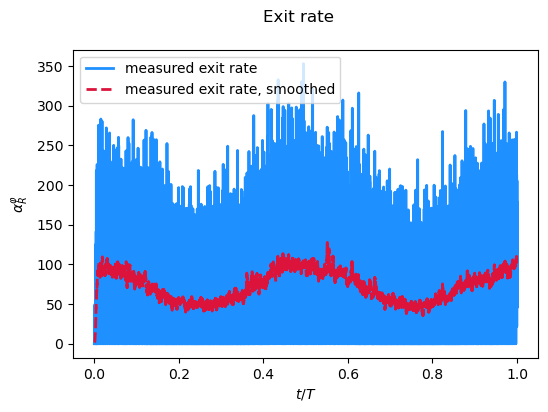

In [8]:
# the output dictionary from cloning_algorithm.run() contains, among others,
# the exit rate and survival probability as a function of time: 
t = results['t']
exit_rate = results['exit_rate']
remainers = results['remainers']
survival_probability = results['survival_probability']

# We also plot a smoothed version of the exit rate
def smooth_time_series(x,N=200):
        ''' from https://stackoverflow.com/a/33585850 '''
        idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
        return np.mean(x[idx],axis=1)
exit_rate_smoothed = smooth_time_series(exit_rate)
t_smoothed = smooth_time_series(t)


def plot(data):
        fig, ax = plt.subplots(1,1,figsize=(6,4))
        fig.suptitle(data['suptitle'])
        for i,e in enumerate(data['time_series']):
                ax.plot(e[0],e[1],
                        label=e[2],ls=e[3],color=e[4],
                        lw=2)
        try:
                if data['ylog']: ax.set_yscale('log')
        except KeyError:
                pass
        ax.set_xlabel(data['xlabel'])
        ax.set_ylabel(data['ylabel'])
        try:
                if data['legend']: ax.legend(loc='best')
        except KeyError:
                pass
        #ax.set_xlabel()
        #ax.set_ylabel()
        plt.show()
        plt.close(fig)

data_survival_probability = {'suptitle':"Decay of survival probability",
'xlabel':r'$t/T$',
'ylabel':r'$P_R^{\varphi}(t)$',
'time_series':[[t,survival_probability,'measured survival probability','-',
                        'dodgerblue']],
'ylog':True}
plot(data=data_survival_probability)


data_exit_rate = {'suptitle':"Exit rate",
'xlabel':r'$t/T$',
'ylabel':r'$\alpha_R^{\varphi}$',
'time_series':[[t,exit_rate,'measured exit rate','-',
                        'dodgerblue'],
        [t_smoothed,exit_rate_smoothed,'measured exit rate, smoothed','--',
                        'crimson']],
'legend':True
}

plot(data=data_exit_rate)

# Comparison of numerical sojourn probability with analytical results

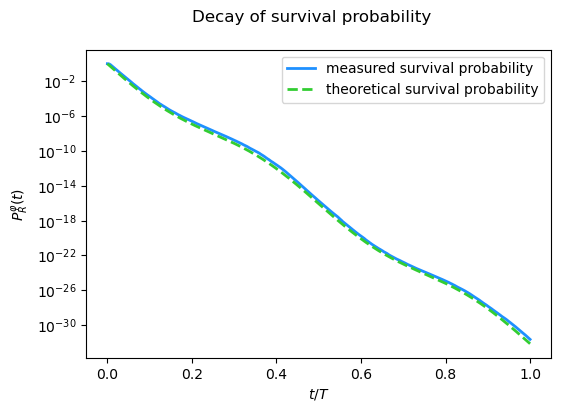

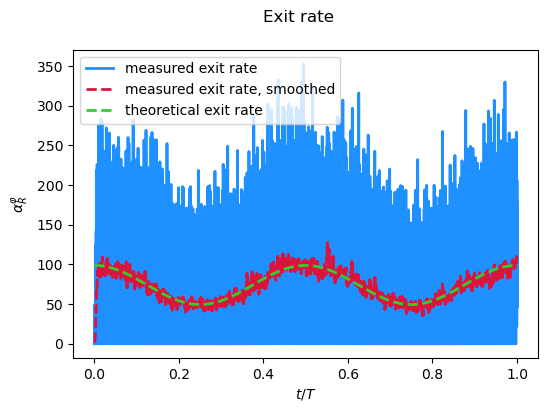

In [9]:
from scipy.integrate import cumtrapz

def sojourn_probability_and_exit_rate(t,condition_detector):
    #
    p = condition_detector.x_func(t) # path
    #
    # time derivative of path
    dp_dt = np.zeros_like(t,dtype=float)
    dp_dt[0] = (p[1] - p[0])/(t[1] - t[0])
    dp_dt[1:-1] = (p[2:] - p[:-2])/(t[2:] - t[:-2])
    dp_dt[-1] = (p[-1] - p[-2])/(t[-1] - t[-2])
    #
    afree = D*np.pi**2/(4*R**2) # free-diffusion exit rate
    L = (dp_dt)**2/(4*D) # Onsager-Machlup Lagrangian for drift-free diffusion
    #
    afree_ = cumtrapz(afree*np.ones_like(t),t,initial=0) # running time 
                                                 # integral over 
                                                 # free-diffusion exit rate
    S = cumtrapz(L,t,initial=0) # running time integral over Onsager-Machlup 
                                # Lagrangian
    #
    P = np.exp(- (S + afree_)) # sojourn probability up to time t
    #
    return afree, L, S, P

afree, L, S, P = sojourn_probability_and_exit_rate(t=t,
                                            condition_detector=detector)


data_survival_probability['time_series'].append(
    [t,P,'theoretical survival probability','--','limegreen']
                                    )
data_survival_probability['legend'] = True
plot(data=data_survival_probability)


data_exit_rate['time_series'].append(
    [t,afree + L,'theoretical exit rate','--','limegreen']
                                    )
plot(data=data_exit_rate)

We observe that the theoretical exit rate agrees quite nicely with the smoothed
measured data (lower plot). The theoretical sojourn probability increasingly
deviates from the measured data as time increases (upper plot), which we 
rationalize by error accumulation.

Here are the final values for the sojourn probability:

In [10]:
print("Measured sojourn probability = {0:3.3e}".format(
                                            survival_probability[-1]))
print("Theoretical sojourn probability = {0:3.3e}".format(P[-1]))

Measured sojourn probability = 2.242e-32
Theoretical sojourn probability = 7.123e-33


Note that with our algorithm, we measured a probability of the order of $10^{-32}$. If a single trajectory could be generated in 1ms (which is a very very optimistic estimate), then to generate $10^{32}$ trajectories we would have to simulate for a long time:

In [11]:
output_string = ("Assuming 1ms per trajectory, the simulation time for "
                 "10**32 trajectories is {0:3.1e} years")
print(output_string.format(10**32 * 0.001 / 60 / 60 / 24 / 365))

Assuming 1ms per trajectory, the simulation time for 10**32 trajectories is 3.2e+21 years
